## 🌤️ Klasifikasi Cuaca Menggunakan CNN dan Transfer Learning

- Nama: Lutfi Indra Nur Praditya
- NIM: 202210370311482
- Mata Kuliah: Machine Learning

Notebook ini bertujuan untuk membangun model Deep Learning yang mampu mengklasifikasikan citra cuaca ke dalam 11 kategori (Dew, Fog/Smog, Frost, Glaze, Hail, Lightning, Rain, Rainbow, Rime, Sandstorm, Snow).

Sesuai ketentuan, kita akan membandingkan 3 arsitektur model:

1. NN Base (Custom): Model dibangun dari nol.
2. MobileNetV2 (Transfer Learning): Model ringan untuk perangkat mobile.
3. ResNet50V2 (Transfer Learning): Model yang lebih dalam (deep) untuk akurasi tinggi.

Dataset diletakkan pada folder: ../data

## 1. Import Library & Config

In [ ]:
# Cell 2: Import Library & Config
# ... (Import library tetap sama seperti sebelumnya) ...
import os
import glob  
import random
import numpy as np
import pandas as pd
import math   # <--- ini yang kurang
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# --- KONFIGURASI PATH BARU ---
# Karena ipynb ada di dalam 'src', maka folder data dan model ada di sebelah file ini.
DATA_DIR = 'data'   
MODEL_DIR = 'model' 

# Membuat folder 'model' otomatis jika belum ada
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Folder '{MODEL_DIR}' berhasil dibuat.")
else:
    print(f"Folder '{MODEL_DIR}' sudah ada.")

IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
EPOCHS = 20 # (Ingat, turunkan jadi 5 jika terlalu lama di CPU)
SEED = 42

print(f"TensorFlow Version: {tf.__version__}")
print(f"Data Directory: {os.path.abspath(DATA_DIR)}")
print(f"Model Directory: {os.path.abspath(MODEL_DIR)}")

Folder 'model' sudah ada.
TensorFlow Version: 2.20.0
Data Directory: c:\BANK DATA\ALL PRAKTIKUM\SMT 7 - Pembelajaran Mesin\UAP\src\data
Model Directory: c:\BANK DATA\ALL PRAKTIKUM\SMT 7 - Pembelajaran Mesin\UAP\src\model


## 2. EDA (Visualisasi & Analisis)

Sebelum masuk ke pemodelan, kita perlu memahami karakteristik data:
1. Distribusi Kelas: Apakah data seimbang (balanced) atau tidak.
2. Sampel Data: Memastikan citra dapat terbaca dengan baik.

Kelas ditemukan (11): ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


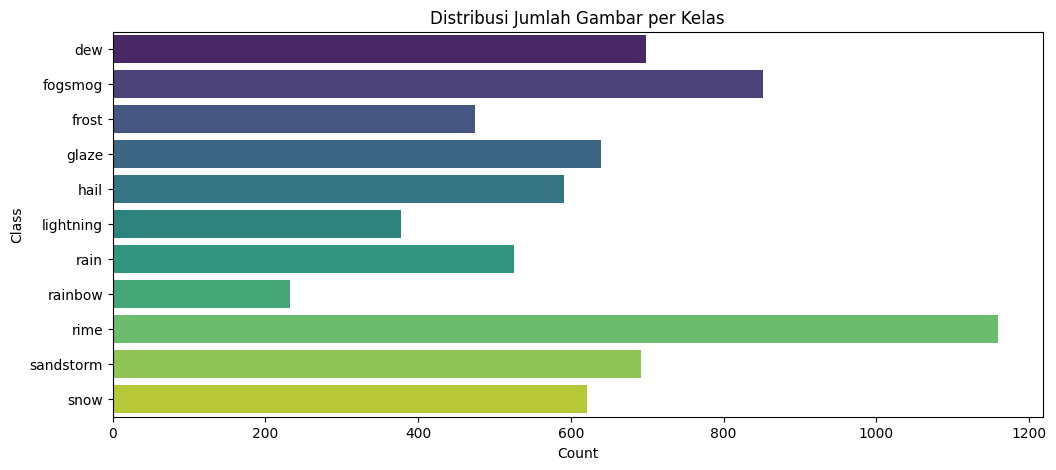

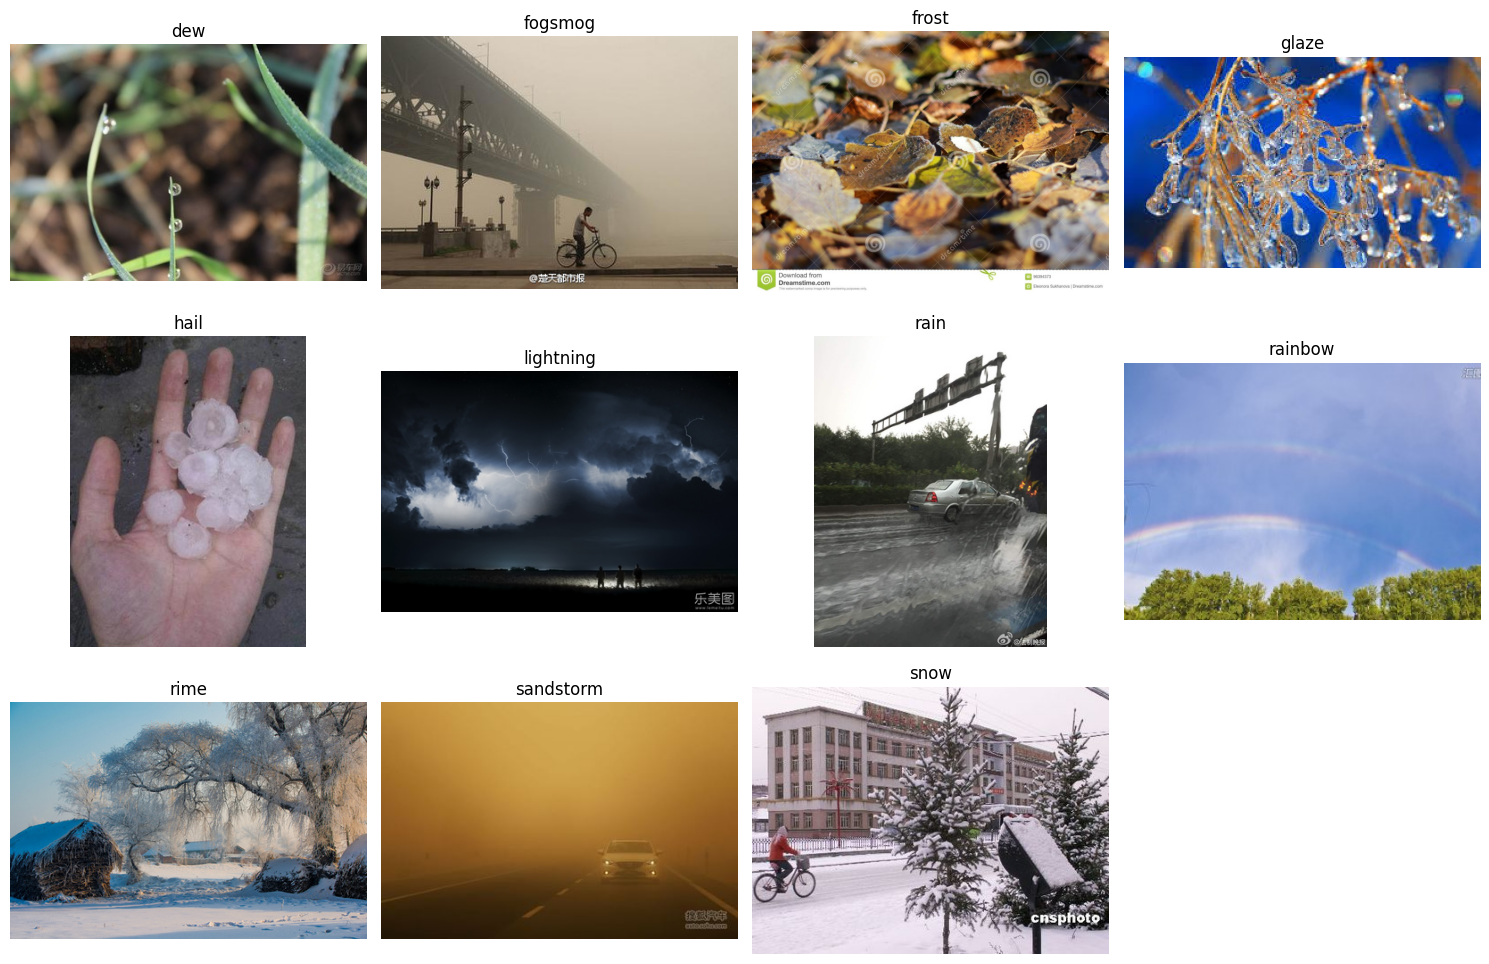

In [2]:
# Mendapatkan list kelas
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(classes)
print(f"Kelas ditemukan ({num_classes}): {classes}")

# 1. Cek Distribusi Kelas
class_counts = {}
for cls in classes:
    cls_path = os.path.join(DATA_DIR, cls)
    class_counts[cls] = len(os.listdir(cls_path))

df_dist = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(12, 5))
sns.barplot(x='Count', y='Class', data=df_dist, palette='viridis', hue='Class', legend=False)
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.show()

# 2. Visualisasi Sampel
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    cls_folder = os.path.join(DATA_DIR, cls)
    random_img = random.choice(os.listdir(cls_folder))
    img_path = os.path.join(cls_folder, random_img)
    img = mpimg.imread(img_path)
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Data Load & Splitting

Kita akan menggunakan *`image_dataset_from_directory`* untuk memuat data. Skema pembagian data:

- Training: 70%
- Validation: 15%
- Testing: 15%

In [3]:
# Load Training Data (70% training, 30% untuk val+test sementara)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Load Validation+Test Data (30% sisanya)
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Split Validation dan Test (masing-masing 15% dari total)
val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

print(f"Batch Train: {tf.data.experimental.cardinality(train_ds)}")
print(f"Batch Val: {tf.data.experimental.cardinality(val_ds)}")
print(f"Batch Test: {tf.data.experimental.cardinality(test_ds)}")

# Optimasi Performa (Caching & Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6862 files belonging to 11 classes.
Using 4804 files for training.
Found 6862 files belonging to 11 classes.
Using 2058 files for validation.
Batch Train: 151
Batch Val: 33
Batch Test: 32


In [5]:
# Helper Function: Plot History & Evaluasi
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend(loc='upper right')
    plt.show()

def evaluate_model(model, test_ds, class_names):
    y_pred = []
    y_true = []
    
    print("Melakukan prediksi pada data test...")
    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def predict_random_display(model, class_names, source_dir, num_images=11):
    """
    Mengambil gambar acak dari folder, melakukan prediksi, dan menampilkan hasilnya beserta skor akurasi.
    """
    # Mengumpulkan semua path gambar
    all_image_paths = []
    for cls in class_names:
        class_folder = os.path.join(source_dir, cls)
        # Mengambil file gambar (jpg, png, jpeg)
        images = glob.glob(os.path.join(class_folder, "*"))
        all_image_paths.extend(images)
    
    # Memilih 11 gambar secara acak
    if len(all_image_paths) < num_images:
        selected_paths = all_image_paths
    else:
        selected_paths = random.sample(all_image_paths, num_images)
    
    # Menyiapkan Plot (Grid 3 baris x 4 kolom = 12 slot, 1 kosong)
    cols = 4
    rows = math.ceil(num_images / cols)
    plt.figure(figsize=(15, 4 * rows))
    
    print(f"--- Prediksi {num_images} Gambar Acak ---")
    
    for i, img_path in enumerate(selected_paths):
        # Load gambar & Preprocessing
        # Kita pakai load_img dari keras agar ukurannya langsung pas (224,224)
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img)
        img_batch = tf.expand_dims(img_array, 0) # Menambah dimensi batch (1, 224, 224, 3)
        
        # Prediksi
        # Karena layer preprocessing/rescaling sudah ada DI DALAM model, kita masukkan raw image
        predictions = model.predict(img_batch, verbose=0)
        score = tf.nn.softmax(predictions[0]) # Dapatkan probabilitas (opsional jika output model sudah softmax)
        
        # Ambil kelas dengan probabilitas tertinggi
        pred_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0]) * 100
        pred_label = class_names[pred_idx]
        
        # Ambil label asli dari nama folder
        true_label = os.path.basename(os.path.dirname(img_path))
        
        # Plotting
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        
        # Warna teks: Hijau jika Benar, Merah jika Salah
        color = 'green' if pred_label == true_label else 'red'
        
        plt.title(f"Asli: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}%", color=color, fontsize=10)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

## 4. Implementasi Model

### 4.1. Model 1: CNN Base (Non-Pretrained)
Model ini dibangun dengan arsitektur CNN sederhana: Convolution -> Pooling -> Flatten -> Dense.

In [6]:
model_base = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Rescaling(1./255), # Normalisasi pixel ke 0-1
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("--- Training Model Base CNN ---")
history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

--- Training Model Base CNN ---
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 90s 528ms/step - accuracy: 0.4144 - loss: 1.7344 - val_accuracy: 0.6083 - val_loss: 1.1996
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 445ms/step - accuracy: 0.5839 - loss: 1.2553 - val_accuracy: 0.6044 - val_loss: 1.2582
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 455ms/step - accuracy: 0.6328 - loss: 1.1009 - val_accuracy: 0.6567 - val_loss: 1.0577
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 459ms/step - accuracy: 0.6765 - loss: 0.9755 - val_accuracy: 0.6596 - val_loss: 0.9611
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 69s 454ms/step - accuracy: 0.7192 - loss: 0.8580 - val_accuracy: 0.7118 - val_loss: 0.9090
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 447ms/step - accuracy: 0.7612 - loss: 0.7074 - val_accuracy: 0.7070 - val_loss: 0.9143
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.8075 - loss: 0.5876 - val_accuracy: 0.7176 - val_loss: 0.9672
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 499ms/s

Model berhasil disimpan di: model\model_base_cnn.keras


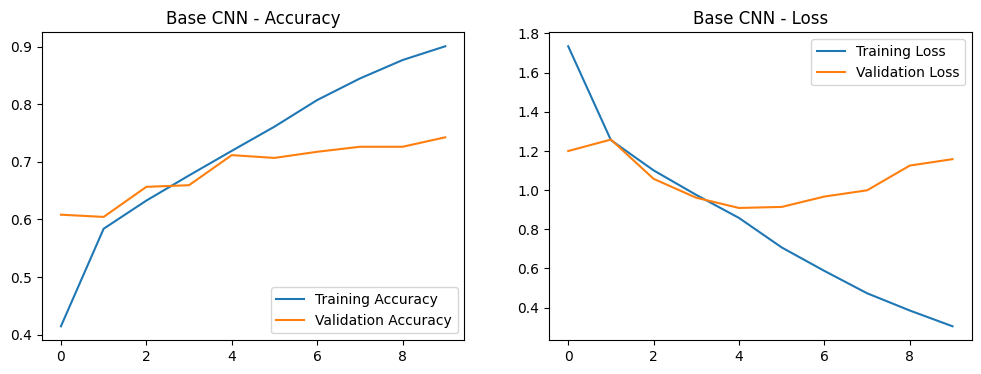

Melakukan prediksi pada data test...

Classification Report:
              precision    recall  f1-score   support

         dew       0.90      0.88      0.89       113
     fogsmog       0.74      0.84      0.78       130
       frost       0.53      0.40      0.45        68
       glaze       0.50      0.55      0.52       103
        hail       0.70      0.67      0.68        79
   lightning       0.81      0.80      0.80        59
        rain       0.66      0.59      0.62        83
     rainbow       1.00      0.45      0.62        40
        rime       0.67      0.84      0.75       161
   sandstorm       0.83      0.82      0.82        99
        snow       0.64      0.52      0.57        89

    accuracy                           0.71      1024
   macro avg       0.72      0.67      0.68      1024
weighted avg       0.71      0.71      0.70      1024



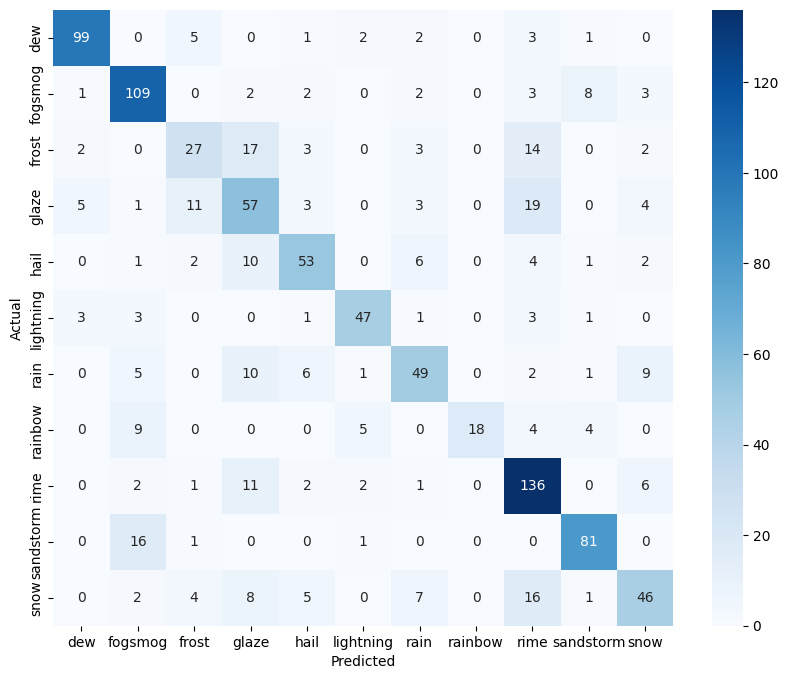

In [7]:
# ... setelah training selesai
save_path = os.path.join(MODEL_DIR, 'model_base_cnn.keras') # UBAH DARI .h5 JADI .keras
model_base.save(save_path)
print(f"Model berhasil disimpan di: {save_path}")

# Evaluasi
plot_history(history_base, "Base CNN")
evaluate_model(model_base, test_ds, classes)

Visualisasi Prediksi Model Base CNN:
--- Prediksi 11 Gambar Acak ---


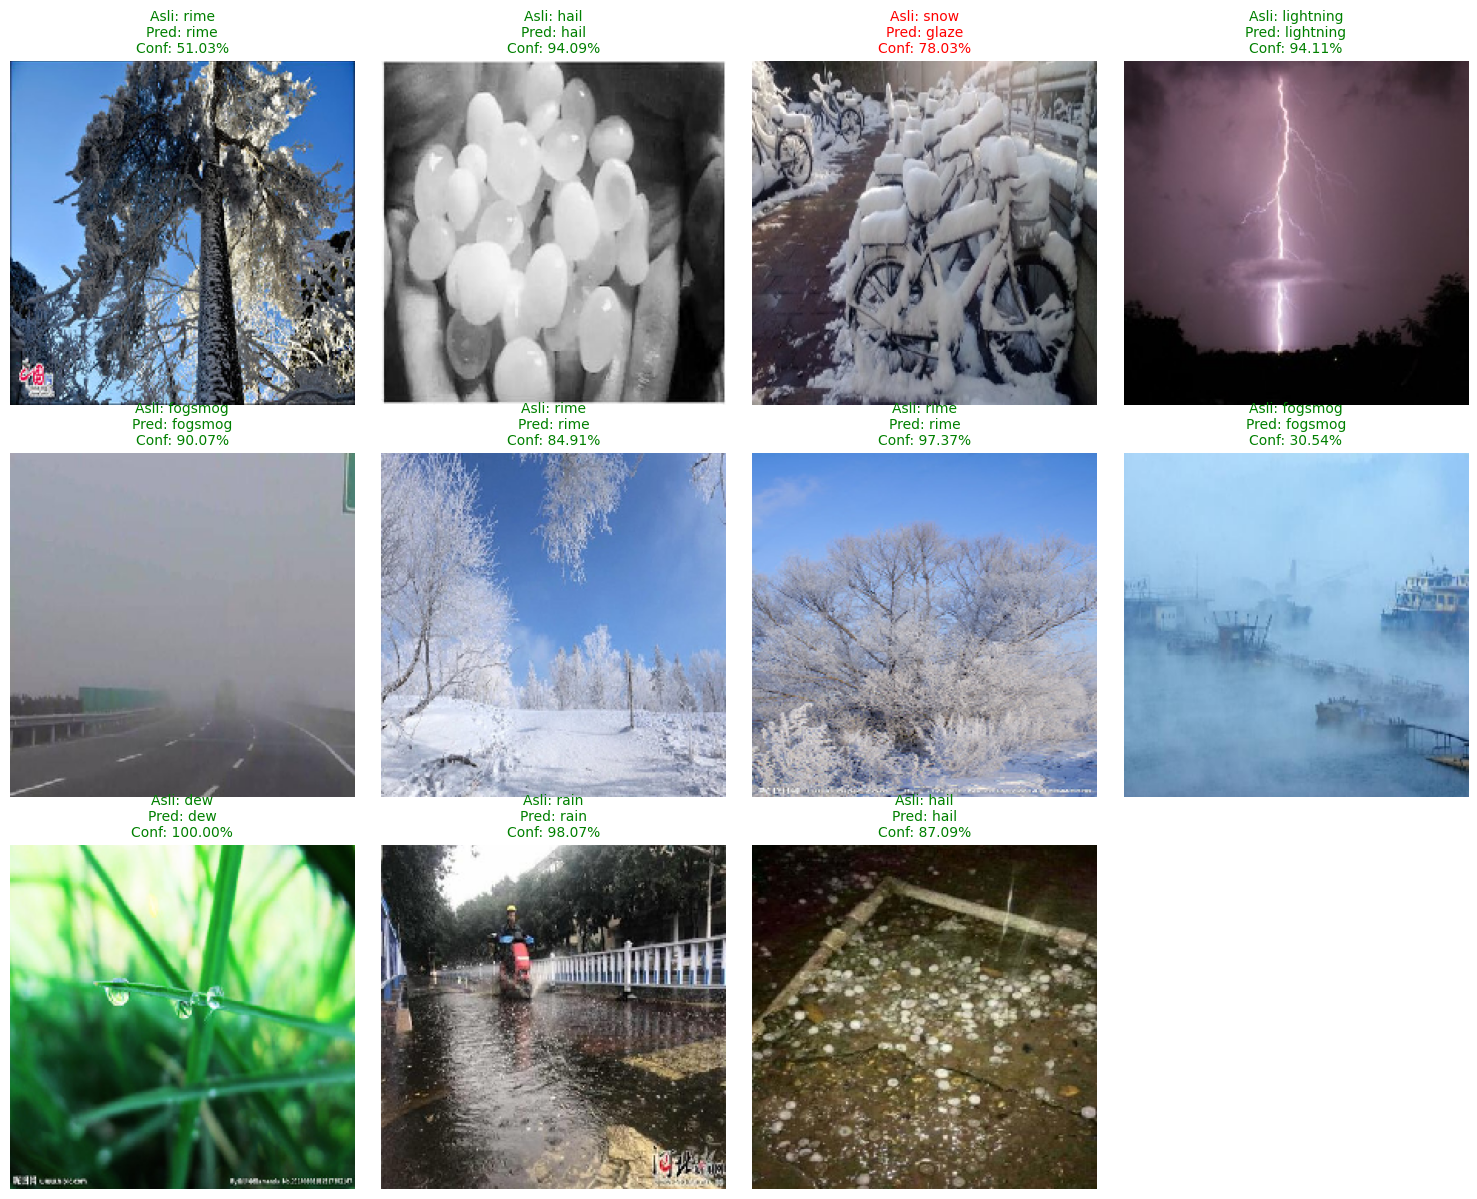

In [ ]:
# Cell Tambahan: Prediksi Acak Model Base
print("Visualisasi Prediksi Model Base CNN:")
predict_random_display(model_base, classes, DATA_DIR, num_images=11)

### 4.2. Model 2: Transfer Learning (MobileNetV2)

Menggunakan **MobileNetV2** yang bobotnya sudah dilatih pada ImageNet. Kita membekukan (freeze) base model dan hanya melatih head (klasifikator) baru.

In [11]:
# Base Model
base_mobilenet = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_mobilenet.trainable = False 

# Arsitektur
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = preprocess_mobilenet(inputs) # Preprocessing bawaan MobileNet (-1 s/d 1)
x = base_mobilenet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_mobilenet = Model(inputs, outputs)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("--- Training MobileNetV2 ---")
history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

--- Training MobileNetV2 ---
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 77s 495ms/step - accuracy: 0.6440 - loss: 1.0467 - val_accuracy: 0.8046 - val_loss: 0.6002
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.8218 - loss: 0.5242 - val_accuracy: 0.8279 - val_loss: 0.5150
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 414ms/step - accuracy: 0.8595 - loss: 0.4163 - val_accuracy: 0.8366 - val_loss: 0.4744
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.8859 - loss: 0.3591 - val_accuracy: 0.8462 - val_loss: 0.4631
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 419ms/step - accuracy: 0.8888 - loss: 0.3163 - val_accuracy: 0.8482 - val_loss: 0.4615
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 420ms/step - accuracy: 0.9015 - loss: 0.2905 - val_accuracy: 0.8491 - val_loss: 0.4422
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 63s 417ms/step - accuracy: 0.9057 - loss: 0.2703 - val_accuracy: 0.8443 - val_loss: 0.4444
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 62s 414ms/step

Model berhasil disimpan di: model\model_mobilenet.keras


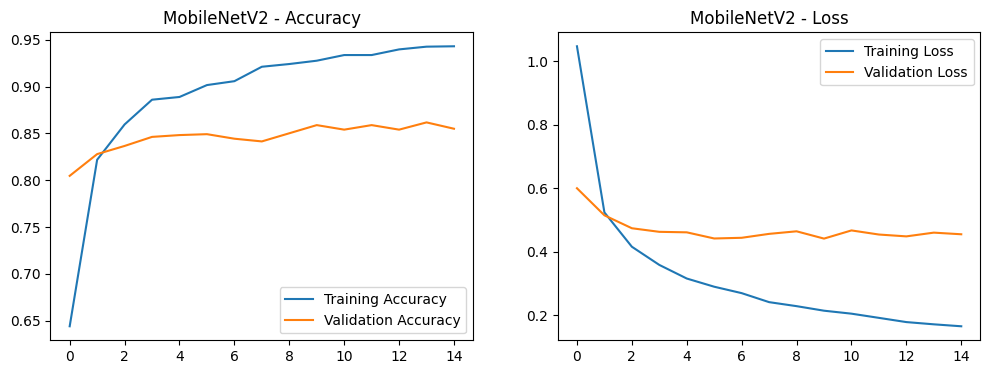

Melakukan prediksi pada data test...

Classification Report:
              precision    recall  f1-score   support

         dew       0.92      0.94      0.93       113
     fogsmog       0.86      0.88      0.87       130
       frost       0.77      0.72      0.74        68
       glaze       0.77      0.77      0.77       103
        hail       0.96      0.96      0.96        79
   lightning       1.00      0.95      0.97        59
        rain       0.93      0.78      0.85        83
     rainbow       1.00      0.95      0.97        40
        rime       0.80      0.89      0.84       161
   sandstorm       0.84      0.88      0.86        99
        snow       0.77      0.74      0.75        89

    accuracy                           0.86      1024
   macro avg       0.88      0.86      0.87      1024
weighted avg       0.86      0.86      0.86      1024



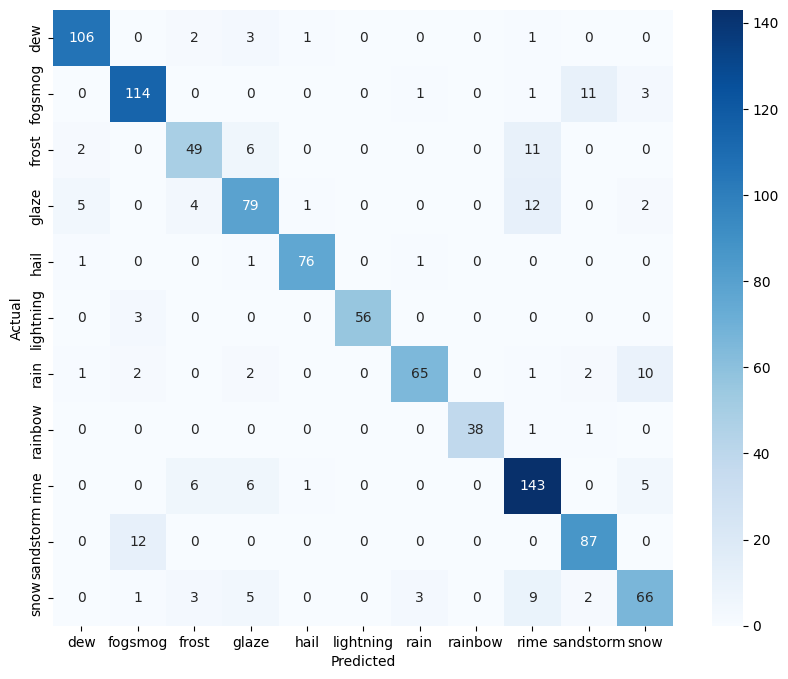

In [12]:
# ... setelah training selesai
save_path = os.path.join(MODEL_DIR, 'model_mobilenet.keras') # UBAH DARI .h5 JADI .keras
model_mobilenet.save(save_path)
print(f"Model berhasil disimpan di: {save_path}")

# Evaluasi
plot_history(history_mobilenet, "MobileNetV2")
evaluate_model(model_mobilenet, test_ds, classes)

Visualisasi Prediksi Model MobileNetV2:
--- Prediksi 11 Gambar Acak ---


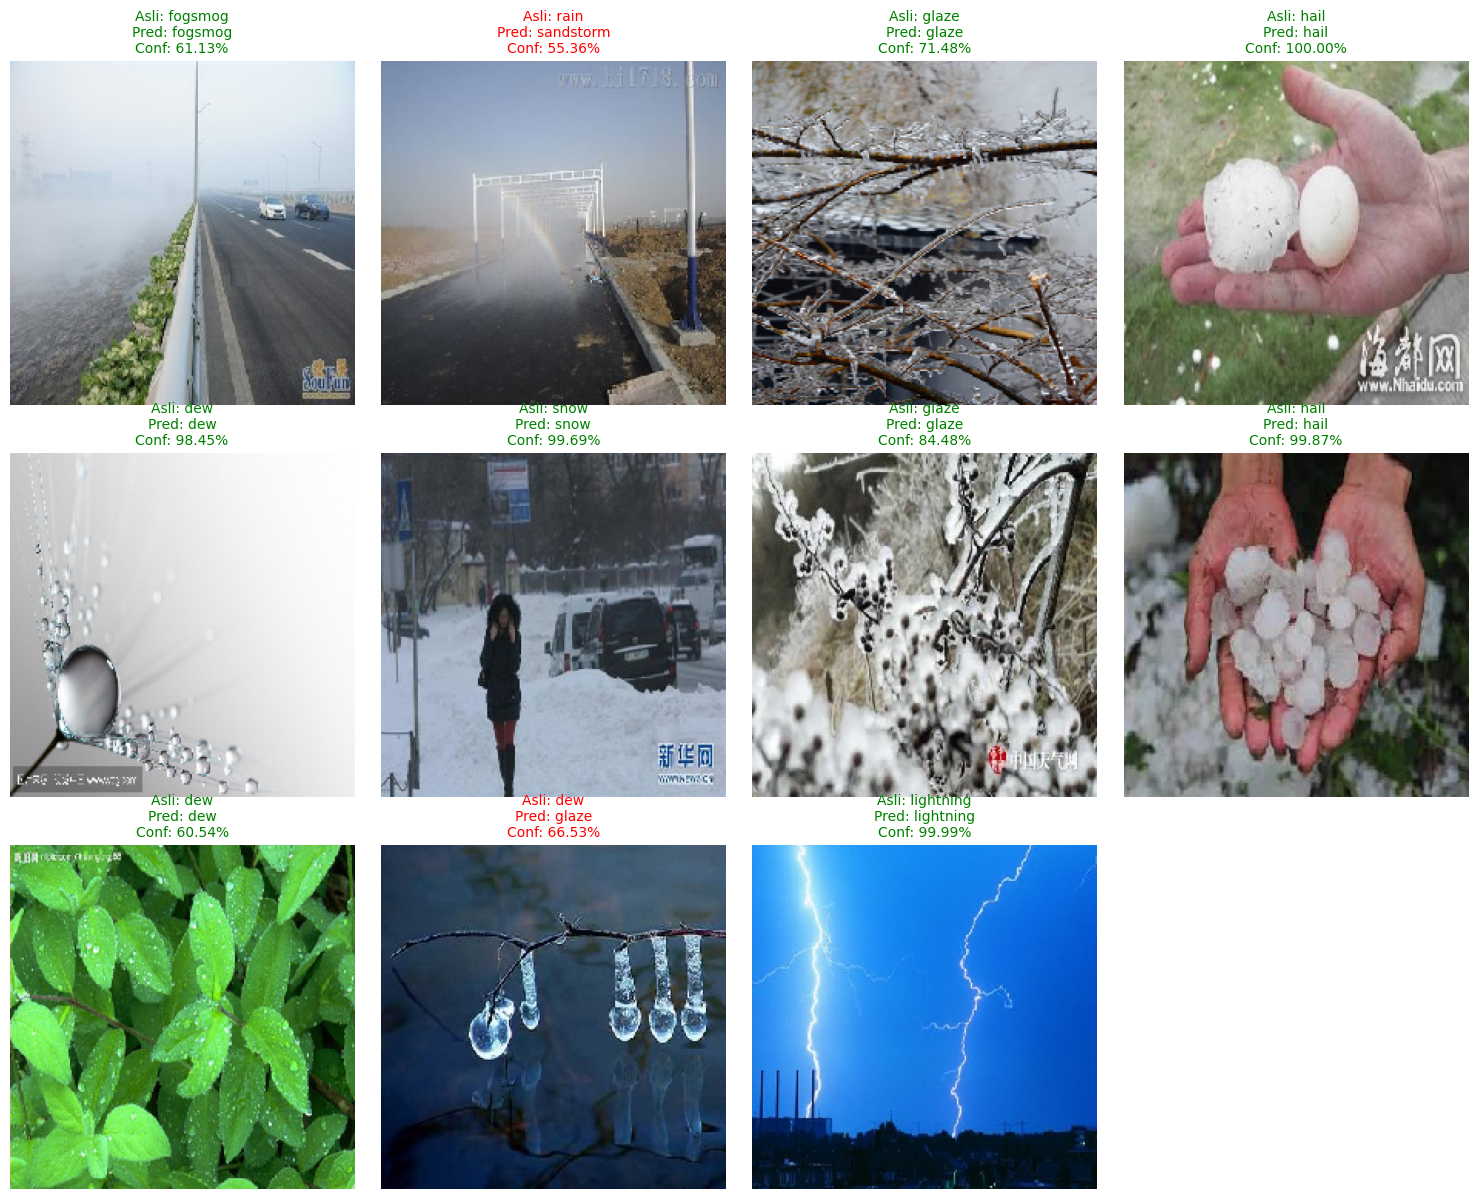

In [13]:
# Cell Tambahan: Prediksi Acak MobileNetV2
print("Visualisasi Prediksi Model MobileNetV2:")
predict_random_display(model_mobilenet, classes, DATA_DIR, num_images=11)

### 4.3. Model 3: Transfer Learning (ResNet50V2)

Menggunakan **ResNet50V2**, arsitektur yang lebih kompleks dengan residual connections untuk menangkap fitur yang lebih detail.

In [14]:
# Base Model
base_resnet = ResNet50V2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_resnet.trainable = False

# Arsitektur
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = preprocess_resnet(inputs)
x = base_resnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs, outputs)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("--- Training ResNet50V2 ---")
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

--- Training ResNet50V2 ---
Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 141s 905ms/step - accuracy: 0.7627 - loss: 0.7372 - val_accuracy: 0.8472 - val_loss: 0.4617
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 132s 878ms/step - accuracy: 0.8853 - loss: 0.3293 - val_accuracy: 0.8617 - val_loss: 0.4061
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 133s 883ms/step - accuracy: 0.9215 - loss: 0.2260 - val_accuracy: 0.8704 - val_loss: 0.3957
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 133s 881ms/step - accuracy: 0.9430 - loss: 0.1677 - val_accuracy: 0.8694 - val_loss: 0.4141
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 134s 888ms/step - accuracy: 0.9638 - loss: 0.1168 - val_accuracy: 0.8607 - val_loss: 0.4971
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 139s 919ms/step - accuracy: 0.9738 - loss: 0.0858 - val_accuracy: 0.8772 - val_loss: 0.4383
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 135s 892ms/step - accuracy: 0.9817 - loss: 0.0631 - val_accuracy: 0.8704 - val_loss: 0.4784
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 133s 883

Model berhasil disimpan di: model\model_resnet.keras


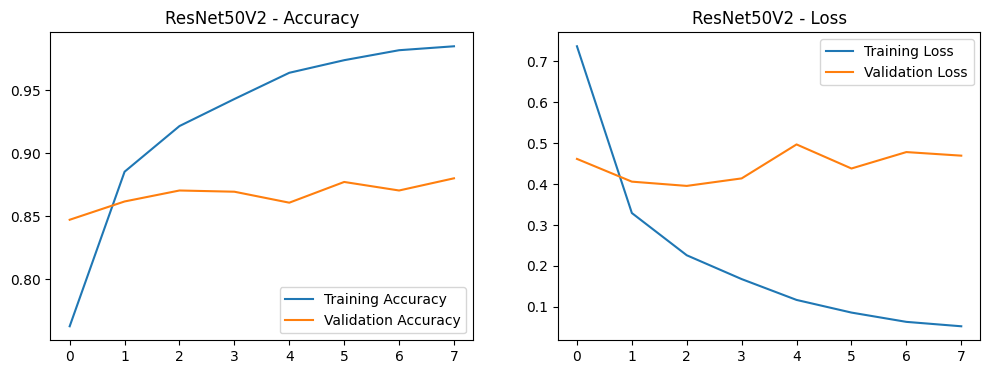

Melakukan prediksi pada data test...

Classification Report:
              precision    recall  f1-score   support

         dew       0.96      0.94      0.95       113
     fogsmog       0.88      0.92      0.89       130
       frost       0.78      0.69      0.73        68
       glaze       0.79      0.75      0.77       103
        hail       0.88      0.94      0.91        79
   lightning       0.94      0.98      0.96        59
        rain       0.94      0.72      0.82        83
     rainbow       0.97      0.93      0.95        40
        rime       0.78      0.90      0.84       161
   sandstorm       0.91      0.86      0.89        99
        snow       0.73      0.78      0.75        89

    accuracy                           0.86      1024
   macro avg       0.87      0.85      0.86      1024
weighted avg       0.86      0.86      0.86      1024



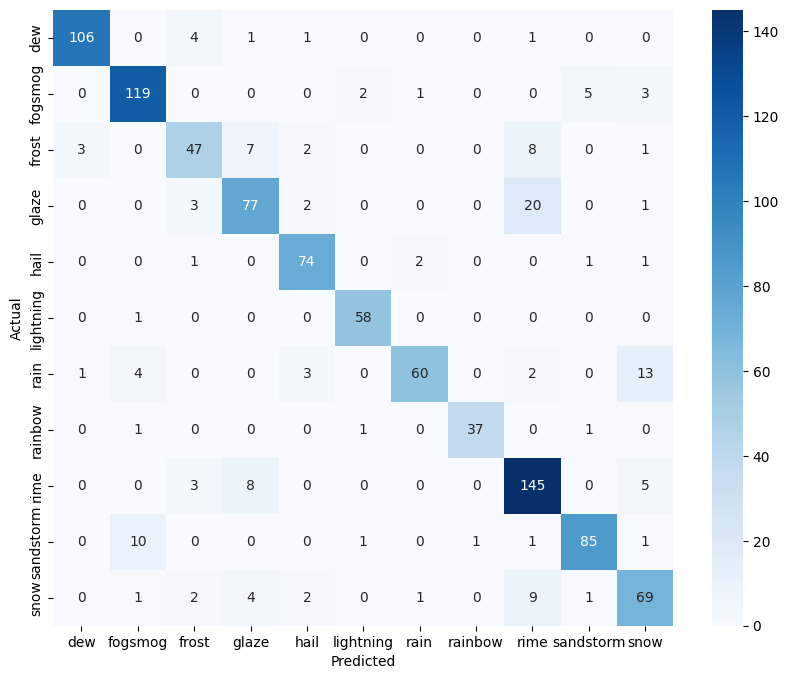

In [15]:
# ... setelah training selesai
save_path = os.path.join(MODEL_DIR, 'model_resnet.keras') # UBAH DARI .h5 JADI .keras
model_resnet.save(save_path)
print(f"Model berhasil disimpan di: {save_path}")

# Evaluasi
plot_history(history_resnet, "ResNet50V2")
evaluate_model(model_resnet, test_ds, classes)

Visualisasi Prediksi Model ResNet50V2:
--- Prediksi 11 Gambar Acak ---


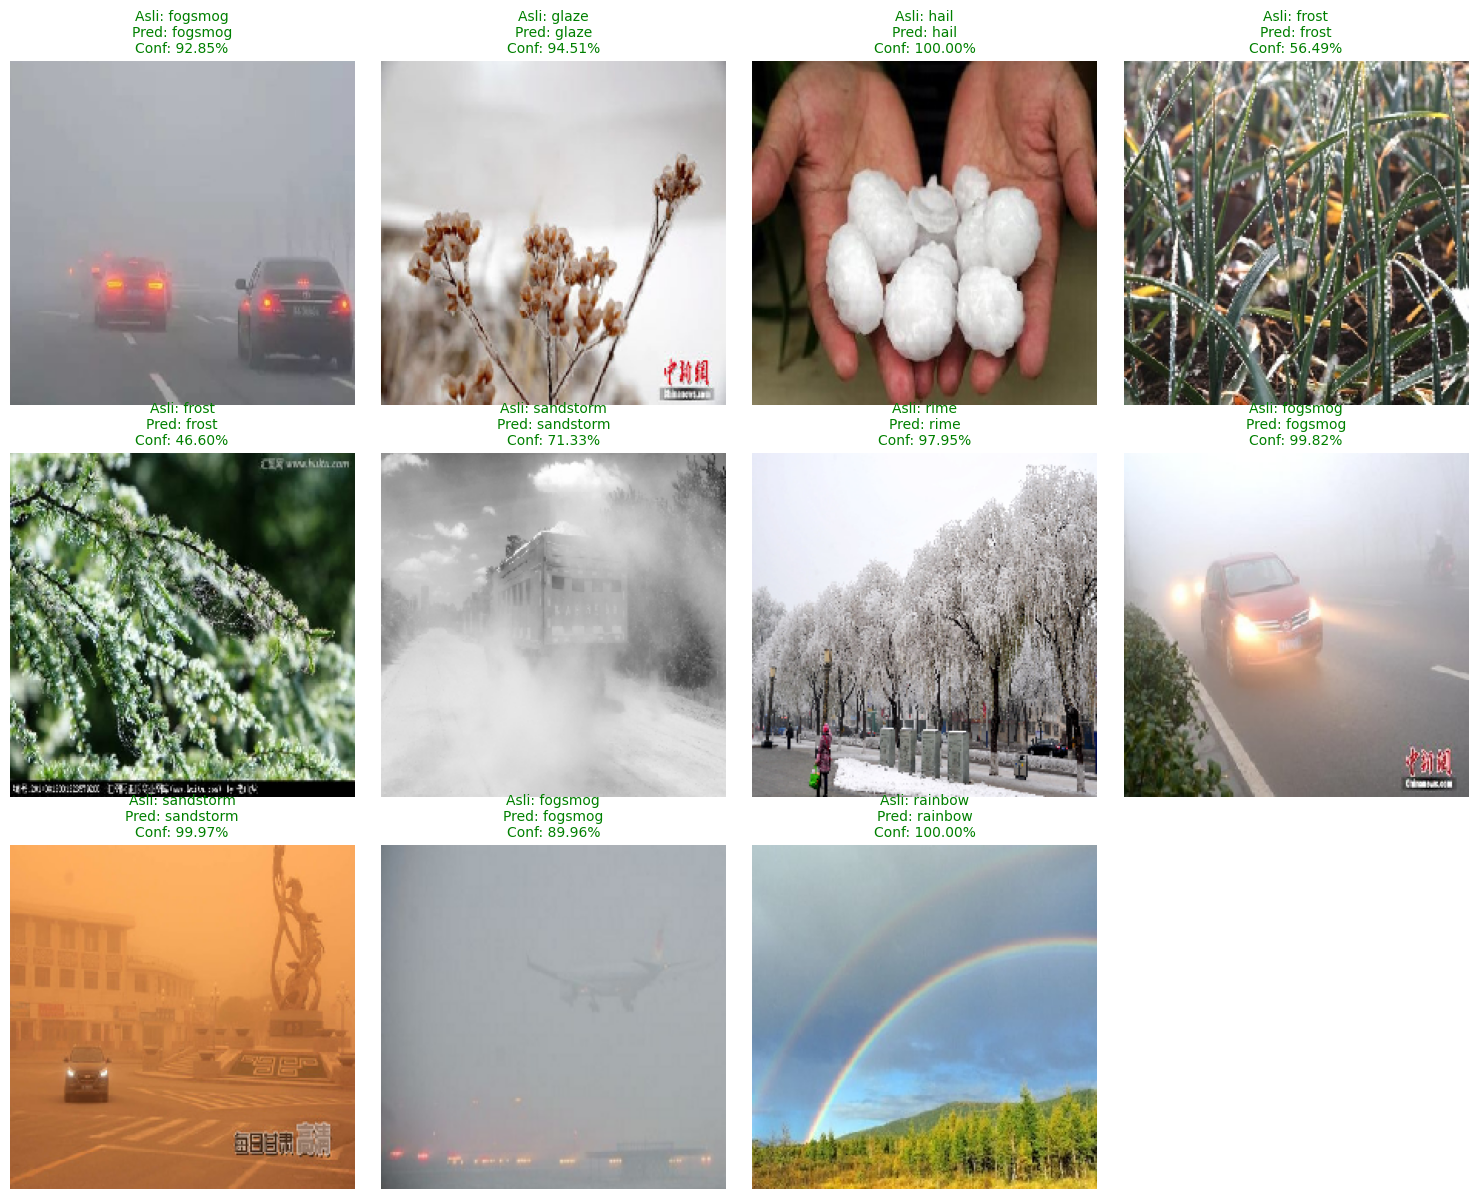

In [16]:
# Cell Tambahan: Prediksi Acak ResNet50V2
print("Visualisasi Prediksi Model ResNet50V2:")
predict_random_display(model_resnet, classes, DATA_DIR, num_images=11)